In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

path_Macrophage_cluster = "/content/drive/My Drive/Hulab/Macrophage.csv"
path_Monocyte_cluster = "/content/drive/My Drive/Hulab/Monocyte.csv"

Macrophage_cluster = pd.read_csv(path_Macrophage_cluster)
Monocyte_cluster = pd.read_csv(path_Monocyte_cluster)

In [4]:
print(Monocyte_cluster.shape)
print(Macrophage_cluster.shape) # last column is treatment outcome

(69, 50)
(69, 49)


In [5]:
filtered_clusters = {
    "Macrophage": Macrophage_cluster.values,
    "Monocyte": Monocyte_cluster.values
}

  C=0.01: No features passed threshold.
  C=0.1: AUC = 0.765 with 1 stable features
  C=1: AUC = 0.905 with 6 stable features
  C=10: AUC = 0.941 with 11 stable features


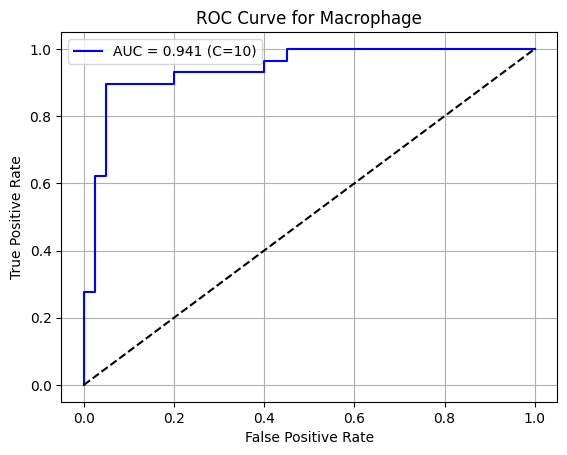

Cluster Macrophage: AUC = 0.941 (C=10)
  C=0.01: No features passed threshold.
  C=0.1: No features passed threshold.
  C=1: AUC = 0.814 with 5 stable features
  C=10: AUC = 0.763 with 15 stable features


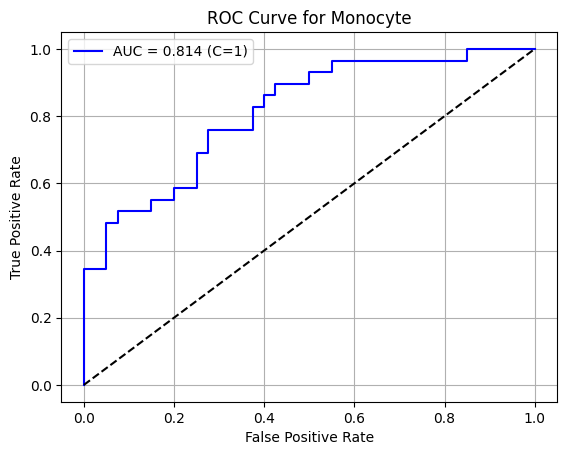

Cluster Monocyte: AUC = 0.814 (C=1)


In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Hyperparameters
n_bootstrap = 100
stability_threshold = 0.7
C_grid = [0.01, 0.1, 1, 10]
random_seed = 42

predicted_outputs_pembro_lasso = {}

for cell_type, filtered_matrix in filtered_clusters.items():
    Xy = filtered_matrix
    X = Xy[:, :-1]
    y = Xy[:, -1]

    # Remove rows with NaNs
    nan_mask = ~np.isnan(X).any(axis=1)
    X = X[nan_mask]
    y = y[nan_mask]

    best_auc = -np.inf
    best_df = None
    best_c = None

    for C in C_grid:
        # Stability selection
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        selection_counts = np.zeros(X.shape[1])
        rng = np.random.RandomState(random_seed)

        for i in range(n_bootstrap):
            idx = rng.choice(len(y), size=len(y), replace=True)
            X_boot, y_boot = X_scaled[idx], y[idx]

            if len(np.unique(y_boot)) < 2:
                continue

            model = LogisticRegression(penalty="l1", solver="saga", C=C, max_iter=10000)
            model.fit(X_boot, y_boot)
            selected = np.abs(model.coef_[0]) > 1e-6
            selection_counts += selected

        freq = selection_counts / n_bootstrap
        selected_features = np.where(freq >= stability_threshold)[0]

        if len(selected_features) == 0:
            print(f"  C={C}: No features passed threshold.")
            continue

        # 5-fold CV using selected features
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
        y_true_all = []
        y_pred_all = []
        sample_id_all = []
        sample_ids = np.arange(len(y))

        for train_idx, test_idx in skf.split(X[:, selected_features], y):
            X_train = X[train_idx][:, selected_features]
            X_test = X[test_idx][:, selected_features]
            y_train = y[train_idx]
            y_test = y[test_idx]
            test_ids = sample_ids[test_idx]

            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            model_final = LogisticRegression(penalty="l1", solver="saga", C=C, max_iter=10000, random_state=42)
            model_final.fit(X_train, y_train)
            y_pred_prob = model_final.predict_proba(X_test)[:, 1]

            y_true_all.extend(y_test)
            y_pred_all.extend(y_pred_prob)
            sample_id_all.extend(test_ids)

        fpr, tpr, _ = roc_curve(y_true_all, y_pred_all)
        auc_score = auc(fpr, tpr)

        print(f"  C={C}: AUC = {auc_score:.3f} with {len(selected_features)} stable features")

        if auc_score > best_auc:
            best_auc = auc_score
            best_c = C
            best_df = pd.DataFrame({
                "Sample_ID": sample_id_all,
                "True_Label": y_true_all,
                "Predicted_Probability": y_pred_all
            }).sort_values("Sample_ID").reset_index(drop=True)

    # ROC plot
    if best_df is not None:
        predicted_outputs_pembro_lasso[cell_type] = best_df

        fpr, tpr, _ = roc_curve(best_df["True_Label"], best_df["Predicted_Probability"])
        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC = {best_auc:.3f} (C={best_c})", color='blue')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for {cell_type}")
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"Cluster {cell_type}: AUC = {best_auc:.3f} (C={best_c})")